In [1]:
from gappyfpca.fpca import *
from gappyfpca.eig import fpca_num_coefs
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# generate synthetic dataset to test

# Parameters
M = 1000  # Number of functions
L = 50   # Length of each function

# Sinusoidal patterns with random frequencies and phases
#x = np.linspace(0, 2 * np.pi, L)
#functions = np.array([10+np.random.uniform(0.1, 5)*np.sin(x * np.random.uniform(1, 1.5) + np.random.uniform(0,  np.pi/2)) 
#                      for _ in range(M)])

# Random polynomials
functions = np.array([np.polyval(np.random.uniform(-1, 1, size=3), np.linspace(-1, 1, L)) 
                      for _ in range(M)])

data=np.copy(functions)
#artifically gappy it
for i in range(M):
    # Determine the number of NaNs to insert (0 to <50% of the function length)
    num_nans = np.random.randint(0, L // 2)  
    # Randomly select indices to replace with NaN
    nan_indices = np.random.choice(L, num_nans, replace=False)
    # Replace selected indices with NaN
    data[i, nan_indices] = np.nan



In [17]:
# perform fPCA on non gappy data to compare (1 iteration)
fpca_comps_full, fpca_coefs_full, _, _ = gappyfpca(functions,max_iter=1)

[ 1.86433393e+03  6.06470897e+02  1.36236352e+02  1.27897692e-13
  1.09658156e-13  5.68434189e-14  5.28489485e-14  4.26325641e-14
  4.12222350e-14  3.00603868e-14  2.84217094e-14  2.84217094e-14
  2.74428170e-14  2.42790968e-14  2.13162821e-14  1.82911012e-14
  1.53159196e-14  1.48430009e-14  1.42108547e-14  1.42108547e-14
  1.42108547e-14  1.03579411e-14  7.81775823e-15  7.10542736e-15
  7.10542736e-15  3.69659991e-15 -1.20424554e-15 -4.30739907e-15
 -5.60594542e-15 -7.10542736e-15 -7.10542736e-15 -7.10542736e-15
 -8.36272525e-15 -1.42108547e-14 -1.42108547e-14 -1.45792098e-14
 -1.52798652e-14 -2.13162821e-14 -2.13162821e-14 -2.13162821e-14
 -2.13162821e-14 -2.84217094e-14 -2.84217094e-14 -4.00757372e-14
 -4.08095974e-14 -4.12571934e-14 -7.46938868e-14 -9.23705556e-14
 -9.23705556e-14 -1.76595524e-13]
[0.         0.71511488 0.94774292 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.      

In [ ]:
# Generate fpca of gappy data using
fpca_comps,fpca_coefs,evalue,run_stat=gappyfpca(data,max_iter=15,num_iter=10,iparallel=0)

[ 1.82460239e+03  6.18309219e+02  1.36635571e+02  8.65220231e+00
  6.40756979e+00  6.09733544e+00  5.61541346e+00  4.91049483e+00
  4.42091408e+00  4.00556921e+00  3.85506207e+00  3.46860906e+00
  3.28299073e+00  3.18943851e+00  2.91512125e+00  2.44922692e+00
  2.32438648e+00  2.07210073e+00  1.64209636e+00  1.52450313e+00
  1.41357298e+00  1.11615703e+00  9.79050604e-01  7.93055597e-01
  6.76295405e-01  4.20798895e-01  2.89016666e-01  1.20131936e-01
 -2.40633542e-01 -3.62667290e-01 -5.16277756e-01 -7.76959535e-01
 -9.72353972e-01 -1.24379423e+00 -1.49957021e+00 -1.58815832e+00
 -1.80272761e+00 -2.06223251e+00 -2.23382387e+00 -2.61431736e+00
 -2.81143701e+00 -3.12427676e+00 -3.57287095e+00 -3.59602531e+00
 -3.85937650e+00 -4.21917955e+00 -4.38283007e+00 -5.11229176e+00
 -5.81000432e+00 -6.50470783e+00]
[0.         0.70358817 0.94201549 0.99470378 0.99804017 1.000511
 1.00286221 1.00502758 1.00692112 1.00862588 1.01017047 1.01165703
 1.01299457 1.01426053 1.01549041 1.01661452 1.0175589

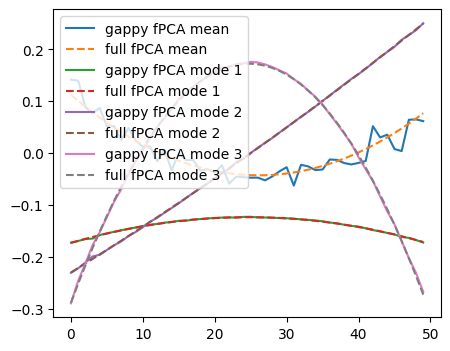

In [14]:
# plot the modes vs non-gappy modes
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.plot(fpca_comps[0,:],label='gappy fPCA mean')
ax.plot(fpca_comps_full[0,:],'--',label='full fPCA mean')
modes_to_plot = min(5,fpca_comps_full.shape[0])
for i in range(1,modes_to_plot):
    ax.plot(fpca_comps[i,:],label='gappy fPCA mode '+str(i))
    ax.plot(fpca_comps_full[i,:],'--',label='full fPCA mode '+str(i))
ax.legend()

In [ ]:
# Impute missing data at 95% explained variance, excludes noise due to missing data

# find number of coefficients
num_coefs=fpca_num_coefs(evalue,0.95)

function_recon=reconstruct_func(fpca_comps[0,:],fpca_comps[1:,:],fpca_coefs,num_coefs=num_coefs)


[1.88579487e+03 5.97604513e+02 1.30395556e+02 3.74069957e+00
 5.63317006e-01 4.71431237e-01 3.38621567e-01 3.15526121e-01
 2.70686421e-01 2.42942182e-01 2.29918268e-01 2.25792145e-01
 2.01709451e-01 1.97912225e-01 1.85458008e-01 1.76685895e-01
 1.66671576e-01 1.61257399e-01 1.52957752e-01 1.43514299e-01
 1.33800451e-01 1.26394960e-01 1.22355865e-01 1.17662118e-01
 1.11041353e-01 1.08898836e-01 1.06025803e-01 1.01098058e-01
 9.63176534e-02 9.33464783e-02 9.09860477e-02 8.83351555e-02
 8.09916109e-02 7.87276503e-02 7.84225695e-02 7.48532847e-02
 6.90139316e-02 6.31213419e-02 6.22955373e-02 5.82014491e-02
 5.40403449e-02 5.14562955e-02 5.06294202e-02 4.77163433e-02
 4.43994488e-02 4.28423318e-02 3.98651648e-02 3.69543750e-02
 3.25294030e-02 2.92259614e-02]
[0.         0.718707   0.94646376 0.99615963 0.99758527 0.99779996
 0.99797963 0.99810868 0.99822893 0.9983321  0.99842468 0.99851231
 0.99859836 0.99867524 0.99875067 0.99882135 0.99888868 0.99895221
 0.99901366 0.99907196 0.99912665 0

Text(0, 0.5, 'y')

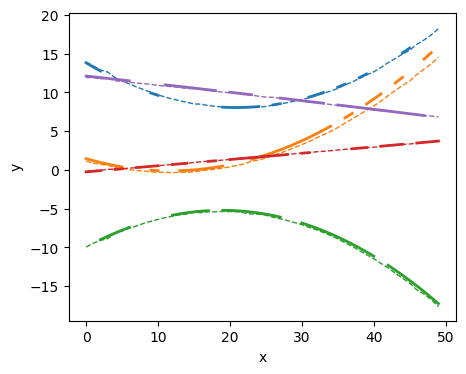

In [15]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
colors = plt.cm.tab10.colors
for i in range(5):
    ax.plot(data[i,:],linestyle='-',linewidth=2,color=colors[i])
    ax.plot(function_recon[i,:],linestyle='--',linewidth=1,color=colors[i])
ax.set_xlabel('x')
ax.set_ylabel('y')